this script calculate the funded proportion of global science

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"

In [16]:
cntry_fund_frac_path='../../data/nf_folder/Data/DerivedData/Derived/cntry_fund_frac.csv'
global_funding_path='../../data/nf_folder/Figs/global_funding.pdf'

In [3]:
pubs_author_funder=pd.read_csv(pubs_path)
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x: literal_eval(x) if pd.notnull(x) else "Not-Funded")
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [4]:
pubs_author_funder['funded']=pubs_author_funder['funder_country'].apply(
    lambda x:1 if x!='Not-Funded' else 0)
pubs_author_funder['IntCol']=pubs_author_funder['author_country'].apply(
    lambda x:1 if len(set(x))>1 else 0)
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,funded,IntCol
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,1,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,1,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,1,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,1,1


assign each paper to its funding country by fractional counting

In [5]:
cntry_fund_frac = []
for index, row in pubs_author_funder.iterrows():
    year=row['year']
    funded=row['funded']
    coll=row['IntCol']
    funder_cntrys=row['funder_country']
    if funder_cntrys=='Not-Funded':
        cntry_fund_frac.append([funder_cntrys,1,year,funded,coll])
    else:
        funder_cntrys=list(set(funder_cntrys))
        n=len(funder_cntrys)
        for c in funder_cntrys:
            cntry_fund_frac.append([c,1/n,year,funded,coll])

In [18]:
cntry_fund_frac_df = pd.DataFrame(cntry_fund_frac,
                                  columns=['fund_cntry','cnt_frac','year','funded','intcol'])
cntry_fund_frac_df.head()

,fund_cntry,cnt_frac,year,funded,intcol
0,Turkey,1.0,2009,1,0
1,United States,1.0,2009,1,1
2,Russia,1.0,2009,1,0
3,Spain,1.0,2009,1,0
4,Spain,1.0,2009,1,1


In [19]:
cntry_fund_frac_df.to_csv(cntry_fund_frac_path,index=False)

remove 'not-funded' paper from calculation

In [20]:
cntry_fund_frac_df=cntry_fund_frac_df[cntry_fund_frac_df.fund_cntry!='Not-Funded']

select the top n countries

In [8]:
n=10
topn=cntry_fund_frac_df.groupby('fund_cntry')[
    'cnt_frac'].sum().sort_values(ascending=False).head(n).index.values

In [9]:
def cal_ratio(data):
    cntry_ratio=data.groupby(['year','fund_cntry'])['cnt_frac'].sum().reset_index(name='count')
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='fund_cntry',values='count',fill_value=0)
    cntry_ratio=cntry_ratio.div(cntry_ratio.sum(axis=1), axis=0)
    return cntry_ratio

In [10]:
def get_topn(cntry_ratio,topnlist):
    topn_df=cntry_ratio[topnlist].reset_index()
    topn_df=topn_df.melt(id_vars='year')
    return topn_df

In [11]:
clist=['#FF8A25','#62988C',]+['#D0D2F2']*8

In [12]:
def plot(data,ax):
    sns.lineplot(x='year',y='value',hue='fund_cntry',data=data,legend=False,ax=ax,hue_order=topn,palette=clist)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

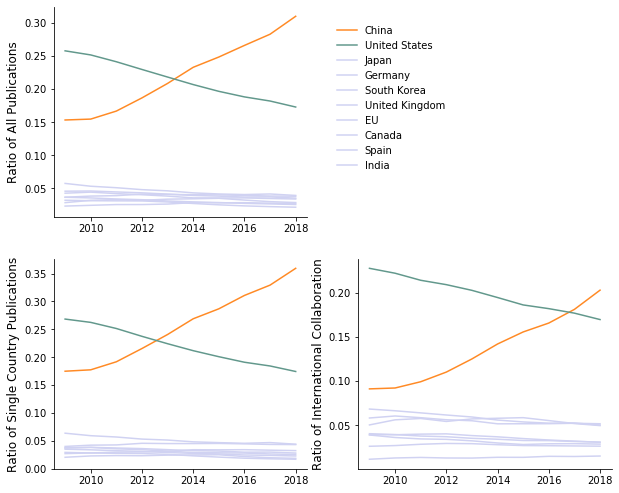

In [17]:
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(10,8.5))

cntry_ratio=cal_ratio(cntry_fund_frac_df)
topn_df=get_topn(cntry_ratio,topn)
plot(topn_df,ax[0][0])
custom_lines=[Line2D([0], [0], color=c) for c in clist]
ax[0][0].legend(custom_lines,topn,loc=(1.1,0.2),fontsize='medium',frameon=False)
ax[0][0].set_xlabel("")
ax[0][0].set_ylabel("Ratio of All Publications",fontsize=12)

ax[0][1].set_visible(False)

cntry_domes=cntry_fund_frac_df[cntry_fund_frac_df.intcol==0]
cntry_domes_ratio=cal_ratio(cntry_domes)
topn_domes=get_topn(cntry_domes_ratio,topn)
plot(topn_domes,ax[1][0])
ax[1][0].set_xlabel("")
ax[1][0].set_ylabel("Ratio of Single Country Publications",fontsize=12)

cntry_int=cntry_fund_frac_df[cntry_fund_frac_df.intcol==1]
cntry_int_ratio=cal_ratio(cntry_int)
topn_int=get_topn(cntry_int_ratio,topn)
plot(topn_int,ax[1][1])
ax[1][1].set_xlabel("")
ax[1][1].set_ylabel("Ratio of International Collaboration",fontsize=12)
plt.savefig(global_funding_path,bbox_inches='tight')